### data setup

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import differential_evolution as de

In [6]:
raw_data = pd.read_csv('dados\MC carpel H 5-min.csv')
raw_data.head(5)

,time,temperature,tga,dtga,dtga_5
0,0,450.35,10.32687,-0.000092,-0.00046
1,5,450.85,10.32643,-0.000088,-0.00044
2,10,451.25,10.32595,-0.000096,-0.00048
3,15,451.65,10.32550,-0.000090,-0.00045
4,20,452.15,10.32502,-0.000096,-0.00048


In [5]:
raw_data.dtypes

time             int64
temperature    float64
tga            float64
dtga           float64
dtga_5         float64
dtype: object

### functions

In [4]:
def time_interval_decorator(function):
    import time
    def wrapper(*args):
        initial_time = time.time()
        func = function(*args)
        final_time = time.time()
        elapsed_time = final_time - initial_time
        print(f'Time elapsed: {elapsed_time} seconds.')
    return wrapper

def fraction(initial_mass, final_mass, instant_mass):
    return (initial_mass - instant_mass) / (initial_mass - final_mass)

def convertion(fraction, order):
    return (1 - fraction)**order

def arrhenius(pre_exp_factor, activation_energy, gas_constant, temperature, convertion):
    rate = pre_exp_factor * np.exp( -activation_energy / (gas_constant * temperature)) * convertion
    return rate

def rpi_model(volatile_mass_fraction, reaction_rate):
    total_reaction_rate = 0
    for component_fraction, component_reaction_rate in zip(volatile_mass_fraction, reaction_rate):
        total_reaction_rate += component_fraction * component_reaction_rate
    
    total_reaction_rate *= -1
    return total_reaction_rate

def rpi_model_for_mass(initial_mass, final_mass, volatile_mass_fraction, reaction_rate):
    return (initial_mass - final_mass) * rpi_model(volatile_mass_fraction, reaction_rate)

def biomass_composition(volatile_mass_fraction, volatile_yield, total_yield):
    return volatile_mass_fraction * volatile_yield / total_yield

def objective_function(calculated_data, real_data):
    obj_fun = 0
    for component_estimate, component_real in zip(calculated_data, real_data):
        obj_fun += (component_estimate - component_real)**2
    return obj_fun


### exploring data

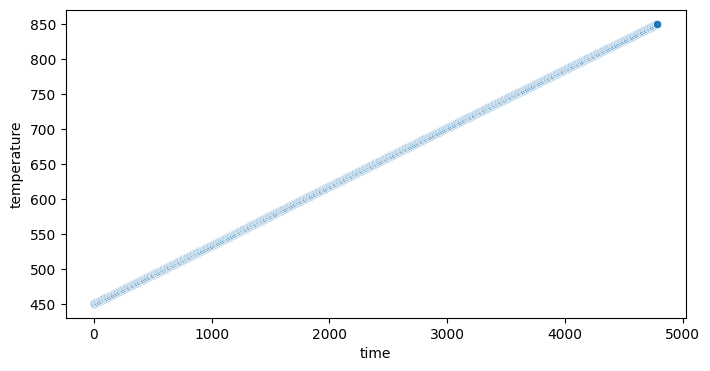

In [8]:
# Checks if the temperature rises linealy
plt.subplots(figsize=(8,4))
sns.scatterplot(data=raw_data,
             x="time",
             y="temperature");

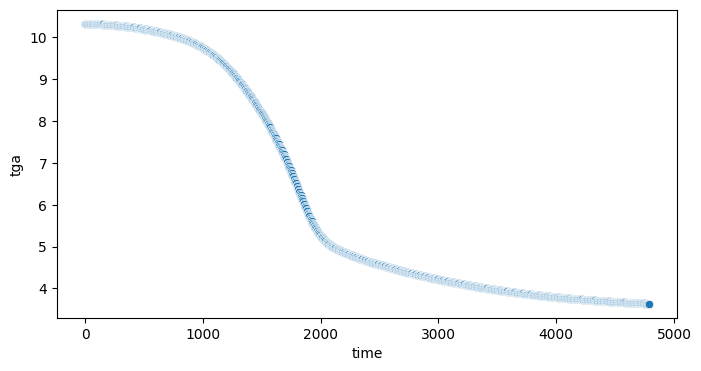

In [9]:
plt.subplots(figsize=(8,4))
sns.scatterplot(data=raw_data,
             x="time",
             y="tga");

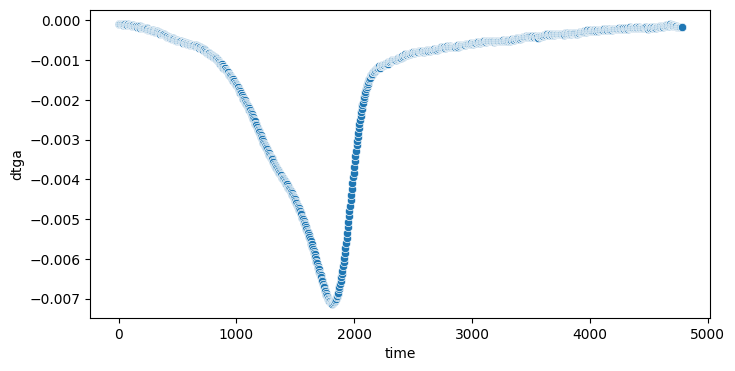

In [10]:
plt.subplots(figsize=(8,4))
sns.scatterplot(data=raw_data,
             x="time",
             y="dtga");

### Guessing initial parameter intervals and hyper parameters for DE

In [13]:
# Bounds follows: [(pre_exp_factor), (activation_energy), (component_fraction), (order)]
hemicellulosis = [(0, 1e10), (0, 1e10), (0, 0.3), (0, 2.0)]
cellulosis = [(0, 1e10), (0, 1e10), (0, 0.5), (0, 2.0)]
lignin = [(0, 1e10), (0, 1e10), (0, 0.3), (0, 4.0)]
bounds = hemicellulosis + cellulosis + lignin

# DE hyper-parameters
strategy='best1bin'
maxiter=1000
popsize=15
tol=1e-2
mutation=(0.5, 1)
recombination=0.7
atol=0

### Main script

In [14]:
@time_interval_decorator
def main():
    results = de(objective_function, bounds)
    params = results.x
    opt_fun = results.fun
    print(f'Params: {params}\nResult: {opt_fun}')